In [1]:
import krippendorff
import numpy as np
import json   
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from collections import Counter


# Globals

In [77]:
language_codes = {
    "en": "English", # TODO: Remove English from the list?
    "es": "Spanish",
    "fr": "French",
    "it": "Italian",
    "pl": "Polish",
    "el": "Greek",
    "nb": "Norwegian",  # Bokmal
    "hu": "Hungarian",
    "fi": "Finnish",
    "lt": "Lithuanian",
}

ablated_models = ["gemma-3-27b-it", "Llama-3.3-70B-Instruct", "Mistral-Small-3.1-24B-Instruct-2503"]

# Paths

In [78]:
gt_annotations_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/511_test_documents_educational_content_human_as_a_judge/human_raw_scores/annotations__educational_content__en__gt.jsonl")
en_documents_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/511_test_documents_educational_content_human_as_a_judge/human_aggregated_scores/511_test_documents_educational_content_en.jsonl")
llm_as_a_judge_metrics_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/output/llm_as_a_judge_metrics")
annotated_500k_samples_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content")
plot_path = Path("/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/output/plots")

if not plot_path.exists():
    plot_path.mkdir(parents=True)

# Human Annotations

In [79]:
def load_gt_annotations(jsonl_path: Path):
    scores = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            obj = json.loads(line)
            row = obj.get("scores")
            cleaned = [int(x) if x is not None else None for x in row] # we get three scores per document
            if cleaned:  # ensure it’s not empty
                scores.append(cleaned)
    return scores

def load_documents(jsonl_path: Path):
    documents = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            obj = json.loads(line)
            documents.append(obj)
    return documents

### Krippendorf Alpha

In [80]:
# Transpose data to shape (annotator, item)
def compute_krippendorff_alpha(annotations):
    data = np.array(annotations).T
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='interval')
    return alpha

In [81]:
annotations = load_gt_annotations(gt_annotations_path)
alpha = compute_krippendorff_alpha(annotations)
print(f"Krippendorff’s alpha (ordinal): {alpha:.3f}")

Krippendorff’s alpha (ordinal): 0.569


### Standard Deviation

In [82]:
gt_annotations = load_gt_annotations(gt_annotations_path)
np.array(gt_annotations).std(axis=1).mean()

np.float64(0.5627472794400139)

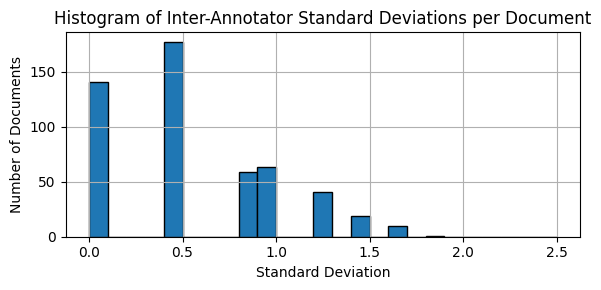

In [83]:
per_doc_stds = np.std(gt_annotations, axis=1, ddof=0)

# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(per_doc_stds, bins=np.linspace(0, 2.5, 26), edgecolor='black')
plt.title('Histogram of Inter-Annotator Standard Deviations per Document')
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.tight_layout()
plt.show()

### Agreement Analysis

In [84]:
annotations = load_gt_annotations(gt_annotations_path)
at_least_two_equal = [int(len(set(row)) < 3) for row in annotations]
print(f"Agreement rate: {sum(at_least_two_equal) / len(at_least_two_equal):.3f}")

Agreement rate: 0.785


### Spread

In [85]:
k = 10
spread = np.array(gt_annotations).max(axis=1) - np.array(gt_annotations).min(axis=1)

In [86]:
# Sort the data
sorted_arr = np.sort(spread)

# Unique values and their cumulative percentages
values = np.unique(sorted_arr)
cdf = [np.mean(spread <= v) * 100 for v in values]  # percentage of elements ≤ v
cdf

[np.float64(27.59295499021526),
 np.float64(62.230919765166334),
 np.float64(86.10567514677103),
 np.float64(97.84735812133071),
 np.float64(100.0)]

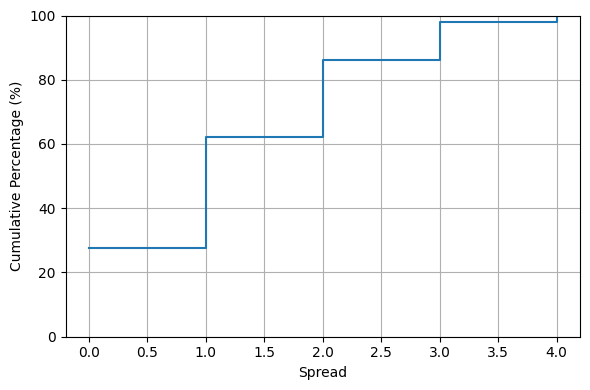

In [87]:
# Plot CDF
plt.figure(figsize=(6, 4))
plt.ylim(0, 100)
plt.step(values, cdf, where="post")
plt.xlabel("Spread")
plt.ylabel("Cumulative Percentage (%)")
# plt.title("Cumulative Distribution of the Spread of Annotations")
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_path / f"human_annotations_cummulative_spread.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [88]:
# documents with largest spread
top_k_spread_doc_ids = spread.argsort()[::-1][:k]
documents = load_documents(en_documents_path)
for doc_id in list(top_k_spread_doc_ids):
    document = documents[doc_id]
    print(f"Document ID 1: {doc_id}")
    print(f"Document ID 2: {document['document_id']}")
    print(f"Scores: {gt_annotations[doc_id]}")
    print(f"Text: {document['text']}")
    print("========================================================================================================")

Document ID 1: 2
Document ID 2: 2
Scores: [4, 1, 0]
Text: Music and Concerts Math
This worksheet is themed around music and concerts, featuring math word problems that incorporate elements of musical performances, ticket sales, and concert logistics. Students are tasked with solving problems that include calculating the average number of songs played at concerts, dividing attendees among stages, and determining the distribution of time for music lessons. The worksheet uses real-life scenarios from the music industry to make math problems more engaging and relevant to students who may have an interest in music. Colorful, music-related illustrations are used to visually enhance the problems, adding to the educational appeal of the worksheet.
The worksheet is designed to teach students how to apply division and other mathematical operations to situations they might encounter in the context of music and concerts. By solving these problems, students practice dividing quantities evenly, calc

### Filtering documents by given scores

In [89]:
doc_ids = np.argwhere(np.all(np.array(gt_annotations)  == [5,5,5], axis=1)).flatten()

In [90]:
documents = load_documents(en_documents_path)
for doc_id in list(doc_ids):
    document = documents[doc_id]
    print(f"Document ID 1: {doc_id}")
    print(f"Document ID 2: {document['document_id']}")
    print(f"Scores: {gt_annotations[doc_id]}")
    print(f"Text: {document['text']}")
    print("========================================================================================================")

Document ID 1: 53
Document ID 2: 53
Scores: [5, 5, 5]
Text: Are you confused about how many ounces are in 1.2 liters? If you’re from a country that primarily uses the metric system, you might find it challenging to convert the volume measurements into imperial units. In this guide, we’ll discuss everything you need to know about converting liters to ounces and vice versa.
This guide will be helpful if you’re cooking something or working with ingredients that require a certain amount of liquid. By the end of this article, you’ll be able to convert liters to ounces effortlessly. Let’s get started!
What is a liter, and what is an ounce?
Before diving into conversions, let’s define what a liter and an ounce mean. A liter is a unit of volume in the metric system, and it’s equal to 1000 milliliters. An ounce, on the other hand, is a unit of volume in the imperial system, and it’s equal to 28.35 milliliters or 1/128th of a U.S. gallon.
How Many Ounces in 1.2 Liters?
To convert liters to ounce

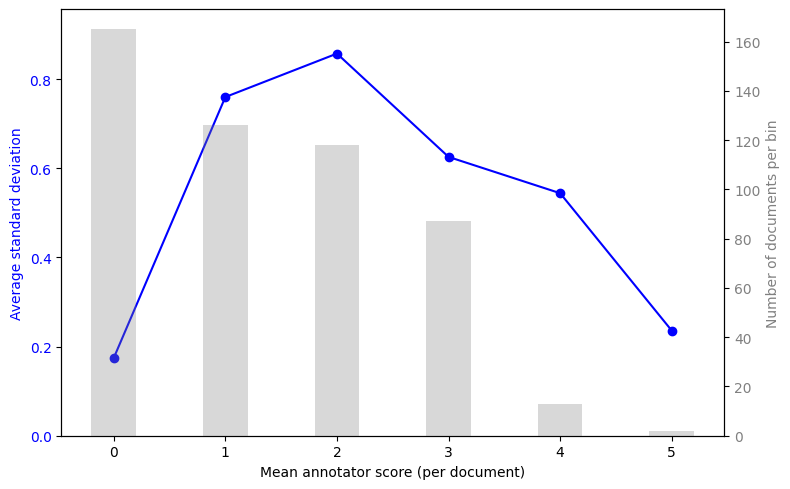

In [91]:

import numpy as np
import matplotlib.pyplot as plt

# Load your annotation data
# Replace this with your actual loading logic
# gt_annotations = load_gt_annotations(gt_annotations_path)
# Ensure it's a NumPy array of shape (num_docs, 3)
gt_annotations = np.array(gt_annotations)

# Compute mean and standard deviation per document
means = np.mean(gt_annotations, axis=1)
stds = np.std(gt_annotations, axis=1, ddof=0)

# Bin the mean scores
bins = np.arange(-0.5, 6, 1)  # Bins: [0.0, 0.5), [0.5, 1.0), ..., [5.0, 5.5)
bin_indices = np.digitize(means, bins)

# Calculate average std and support for each bin
avg_stds_per_bin = [np.mean(stds[bin_indices == i]) for i in range(1, len(bins))]
support_per_bin = [np.sum(bin_indices == i) for i in range(1, len(bins))]

# Compute bin centers for x-axis
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Line plot for average std dev
ax1.plot(bin_centers, avg_stds_per_bin, color='blue', marker='o', label='Avg Std Dev')
ax1.set_xlabel('Mean annotator score (per document)')
ax1.set_ylabel('Average standard deviation', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, max(avg_stds_per_bin) + 0.1)

# Bar plot for support on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(bin_centers, support_per_bin, width=0.4, alpha=0.3, color='gray', label='Support (Count)')
ax2.set_ylabel('Number of documents per bin', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Title and layout
# plt.title('Disagreement vs. Mean Score with Support per Bin')
fig.tight_layout()
plt.savefig(plot_path / f"human_annotation_score_std_hist.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()


In [92]:
# TODO
# * Add plot where x_axis is ground truth and the y_axis the standard deviation of the predictions
# * Could also plot the confusion matrix instead


# LLM-as-a-judge evaluation

In [93]:
results_complete = {}
for path in list(llm_as_a_judge_metrics_path.glob("**/*.json")):
    language = path.parts[-2]
    model = path.stem.split("_")[2]
    if language not in results_complete:
        results_complete[language] = {}
    with open(path, 'r') as f:
        data = json.load(f)
    results_complete[language][model] = data

results_complete

{'bg': {'phi-4': {'metrics': {'Fleiss': 0.2502797242524014,
    'Cohen': 0.2581460372083022,
    'Spearman': 0.6311440245975249,
    'Kendall': 0.524629373412667,
    'Krippendorff': 0.5890210059887584,
    'Invalid': 0,
    'TA-2.0': 0.735812133072407,
    'TA-4.0': 0.8825831702544031,
    'Acc': 0.4187866927592955,
    'MAE': 0.8405088062622307,
    'MSE': 1.4927701674277016,
    'CA-0': 0.489247311827957,
    'CA-1': 0.32,
    'CA-2': 0.3113207547169811,
    'CA-3': 0.5288461538461539,
    'CA-4': 0.23076923076923078,
    'CA-5': 0.0,
    'Macro-F1': 0.3007767238307655,
    'Micro-F1': 0.4187866927592955,
    'F1-0_vs_rest': 0.6190476190476191,
    'F1-1_vs_rest': 0.2831858407079646,
    'F1-2_vs_rest': 0.32195121951219513,
    'F1-3_vs_rest': 0.48672566371681414,
    'F1-4_vs_rest': 0.09375,
    'F1-5_vs_rest': 0.0,
    'F1-0.5': 0.8461538461538461,
    'Recall-0.5': 0.9476923076923077,
    'Precision-0.5': 0.7642679900744417,
    'F1-1.5': 0.749003984063745,
    'Recall-1.5': 0.83

In [107]:
metric_name = "Macro-F1" # "Macro-F1" # "Spearman" # "Macro-F1" # "Spearman" # "NDCG@all"

metric_results = {lang: {model: subsubresult["metrics"][metric_name] for model, subsubresult in subresult.items()} for lang,subresult in results_complete.items()}
metric_results

{'bg': {'phi-4': 0.3007767238307655,
  'Qwen2.5-14B-Instruct': 0.27892558085476743,
  'Llama-3.3-70B-Instruct': 0.28429684004747086,
  'gemma-2-27b-it': 0.19655877639811004,
  'Qwen2.5-32B-Instruct': 0.3737258417905565,
  'Qwen2.5-7B-Instruct': 0.11355093565748602,
  'gemma-3-27b-it': 0.1314626366852865,
  'Mistral-Small-3.1-24B-Instruct-2503': 0.2767890378705405,
  'Llama-3.2-3B-Instruct': 0.08788561489818225,
  'gemma-2-9b-it': 0.2543133455470617,
  'Llama-3.1-8B-Instruct': 0.25640917913565986,
  'Qwen2.5-72B-Instruct': 0.12917755405681397},
 'nn': {'phi-4': 0.30331100804126787,
  'Qwen2.5-14B-Instruct': 0.219855607684768,
  'Llama-3.3-70B-Instruct': 0.32617488476870493,
  'gemma-2-27b-it': 0.2043518470748518,
  'Qwen2.5-32B-Instruct': 0.23588316380290322,
  'Qwen2.5-7B-Instruct': 0.08381818082540476,
  'gemma-3-27b-it': 0.10303833901376303,
  'Mistral-Small-3.1-24B-Instruct-2503': 0.26659042774242714,
  'Llama-3.2-3B-Instruct': 0.15591916400981207,
  'gemma-2-9b-it': 0.2348043699877

In [108]:
metric_df = pd.DataFrame.from_dict(metric_results)
num_languages = len(metric_df.columns)


avg_37 = metric_df.mean(axis=1)
metric_df = metric_df[list(language_codes.keys())]
metric_df["avg-10"] = metric_df.mean(axis=1)
metric_df["avg-37"] = avg_37

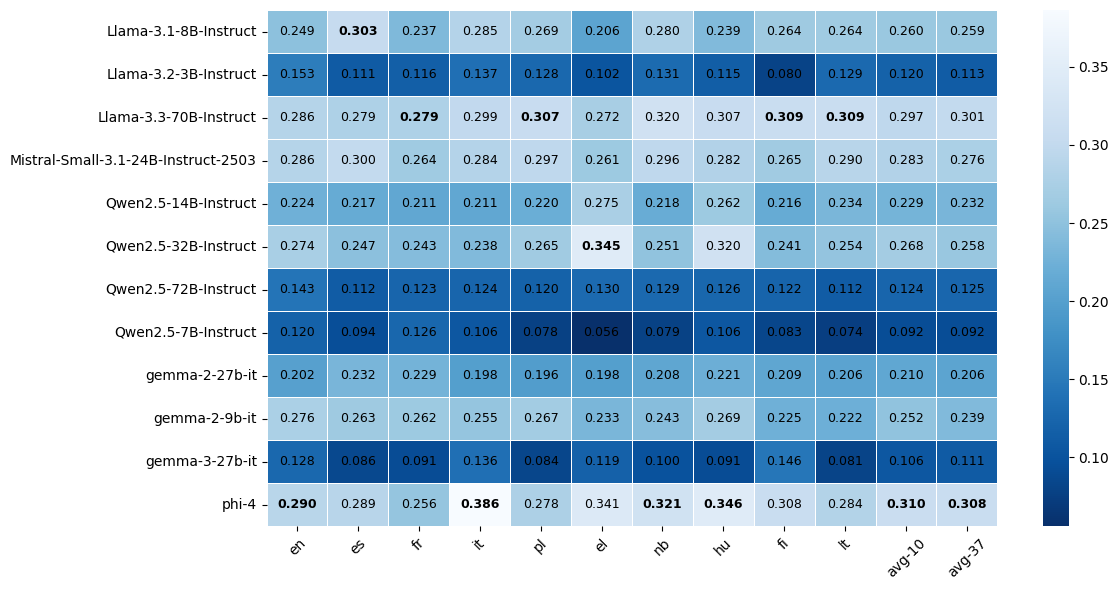

In [109]:

plt.figure(figsize=(12, 6))
metric_df = metric_df.sort_index() 
ax = sns.heatmap(metric_df, annot=False, fmt=".3f", cmap="Blues_r", linewidths=0.5, cbar=True)

# Add text annotations with bold max values
for i, model in enumerate(metric_df.index):
    for j, lang in enumerate(metric_df.columns):
        value = metric_df.iloc[i, j]
        max_val = metric_df[lang].max()
        weight = 'bold' if np.isclose(value, max_val) else 'normal'
        ax.text(j + 0.5, i + 0.5, f"{value:.3f}", 
                ha='center', va='center', color='black', fontsize=9, fontweight=weight)

# Final touches
# plt.title(f"{metric_name}")
# plt.ylabel("Model")
# plt.xlabel("Language")
plt.xticks(ticks=np.arange(len(metric_df.columns)) + 0.5, labels=metric_df.columns, rotation=45)
plt.yticks(ticks=np.arange(len(metric_df.index)) + 0.5, labels=metric_df.index, rotation=0)
plt.tight_layout()

plt.savefig(plot_path / f"llm_annotator_performance_{metric_name}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)


plt.show()

In [21]:
# TODO add avg column for 37 languages

### {F1, Recall, Precision}@threshold

In [22]:
metric_regex = "F1-\w+\.\w+$"
# metric_regex = "Recall-\w+\.\w+$"
# metric_regex = "Precision-\w+\.\w+$"

metric_results = {
    lang: {
        model: {metric_name: score for metric_name, score in subsubresult["metrics"].items() if re.match(metric_regex, metric_name)}
        for model, subsubresult in subresult.items()
    }
    for lang, subresult in results_complete.items()
    if lang in language_codes.keys()
}
metric_results

{'fi': {'phi-4': {'F1-0.5': 0.8406961178045516,
   'F1-1.5': 0.7518248175182481,
   'F1-2.5': 0.5722543352601156,
   'F1-3.5': 0.15053763440860216,
   'F1-4.5': 0.2857142857142857},
  'Qwen2.5-14B-Instruct': {'F1-0.5': 0.7985074626865671,
   'F1-1.5': 0.7368421052631579,
   'F1-2.5': 0.4980544747081712,
   'F1-3.5': 0.13636363636363635,
   'F1-4.5': 0.0},
  'Llama-3.3-70B-Instruct': {'F1-0.5': 0.860655737704918,
   'F1-1.5': 0.7895791583166333,
   'F1-2.5': 0.6163934426229508,
   'F1-3.5': 0.16923076923076924,
   'F1-4.5': 0.08},
  'gemma-2-27b-it': {'F1-0.5': 0.7840772014475271,
   'F1-1.5': 0.7428571428571429,
   'F1-2.5': 0.5523012552301255,
   'F1-3.5': 0.12121212121212122,
   'F1-4.5': 0.0},
  'Qwen2.5-32B-Instruct': {'F1-0.5': 0.8284960422163589,
   'F1-1.5': 0.7265625,
   'F1-2.5': 0.5893416927899686,
   'F1-3.5': 0.1864406779661017,
   'F1-4.5': 0.0},
  'Qwen2.5-7B-Instruct': {'F1-0.5': 0.7784431137724551,
   'F1-1.5': 0.6748466257668712,
   'F1-2.5': 0.5503685503685504,
   'F1

In [23]:
lang_averaged_metric_results = {}
for lang, subresult in metric_results.items():
    for model, metrics in subresult.items():
        if model not in lang_averaged_metric_results:
            lang_averaged_metric_results[model] = {}
        for metric_name, score in metrics.items():
            if metric_name not in lang_averaged_metric_results[model]:
                lang_averaged_metric_results[model][metric_name] = []
            lang_averaged_metric_results[model][metric_name].append(score)

for model, metrics in lang_averaged_metric_results.items():
    for metric_name, scores in metrics.items():
        lang_averaged_metric_results[model][metric_name] = np.mean(scores)
lang_averaged_metric_results

{'phi-4': {'F1-0.5': np.float64(0.847274907527922),
  'F1-1.5': np.float64(0.7510695256897097),
  'F1-2.5': np.float64(0.571604906053786),
  'F1-3.5': np.float64(0.17936122689966869),
  'F1-4.5': np.float64(0.1490299823633157)},
 'Qwen2.5-14B-Instruct': {'F1-0.5': np.float64(0.8003834392456585),
  'F1-1.5': np.float64(0.7296782946778414),
  'F1-2.5': np.float64(0.5430671451547378),
  'F1-3.5': np.float64(0.18648266978872874),
  'F1-4.5': np.float64(0.0)},
 'Llama-3.3-70B-Instruct': {'F1-0.5': np.float64(0.8581688937262477),
  'F1-1.5': np.float64(0.7892528724679936),
  'F1-2.5': np.float64(0.6178853512142768),
  'F1-3.5': np.float64(0.14842852327853853),
  'F1-4.5': np.float64(0.11143962483784509)},
 'gemma-2-27b-it': {'F1-0.5': np.float64(0.7825637109275099),
  'F1-1.5': np.float64(0.7576358996167376),
  'F1-2.5': np.float64(0.5661145846182845),
  'F1-3.5': np.float64(0.1447119447768317),
  'F1-4.5': np.float64(0.0)},
 'Qwen2.5-32B-Instruct': {'F1-0.5': np.float64(0.8332919761866082),

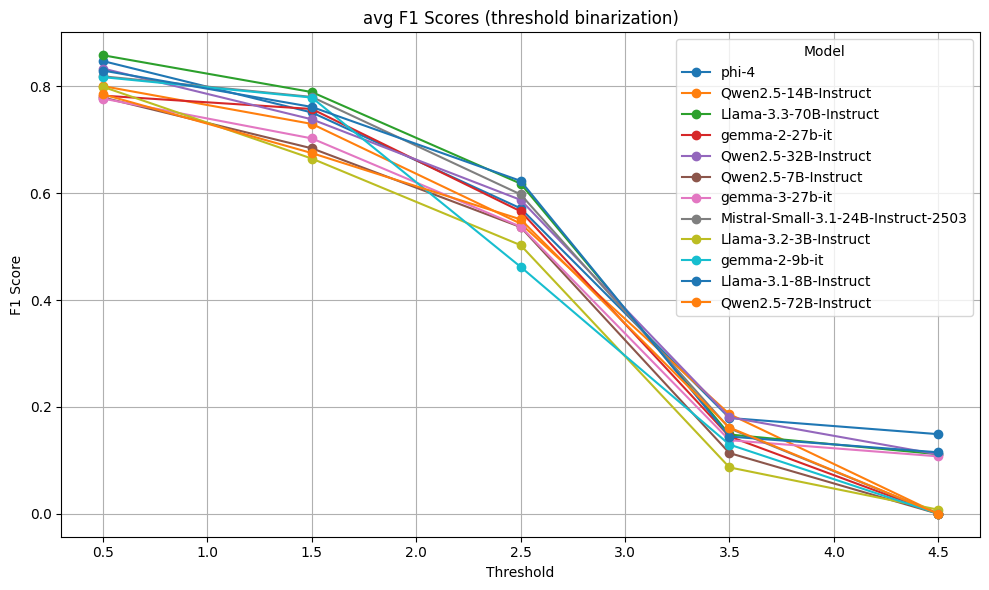

In [24]:
import copy

lang = "avg"
if lang == "avg": 
    threshold_results = copy.deepcopy(lang_averaged_metric_results)
else:
    threshold_results = metric_results[lang]

# Sort threshold labels
threshold_labels = sorted(next(iter(threshold_results.values())).keys(), key=lambda x: float(x.split('-')[1]))
x = [float(label.split('-')[1]) for label in threshold_labels]

# Plot
plt.figure(figsize=(10, 6))
for model, metrics in threshold_results.items():
    y = [metrics[threshold] for threshold in threshold_labels]
    plt.plot(x, y, marker='o', label=model)

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title(f"{lang} F1 Scores (threshold binarization)")
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# TODO check how class imbalance impacts the f1 score 

# Sourced LLM-as-a-judge Training Data

In [59]:
language_codes_500k_docs = {
    "spa": "Spanish",
    "fra": "French",
    "ita": "Italian",
    "pol": "Polish",
    "ell": "Greek", # Modern Greek
    "nob": "Norwegian", # Norwegian Bokmål (dominant variety)
    "hun": "Hungarian",
    "fin": "Finnish",
    "lit": "Lithuanian",
}
model = ablated_models[2]
model_annotations_paths = list((annotated_500k_samples_path / f"{model}_aggregated").glob("**/*.jsonl"))
# filter only the languages that we want to check
model_annotations_paths = {path.stem.split("_")[0]: path for path in model_annotations_paths if path.stem.split("_")[0] in language_codes_500k_docs.keys()}
model_annotations_paths

{'pol': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/pol_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'ita': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/ita_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'fin': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/fin_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'ell': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregate

In [60]:
lang_to_scores = {lang: list() for lang in model_annotations_paths.keys()}

for lang, model_annotations_path in model_annotations_paths.items():
    with open(model_annotations_path, 'r') as f:
        for line in f:
            json_line = json.loads(line)
            try:
                score = float(json_line["score"])
            except: 
                continue
            lang_to_scores[lang].append(score)

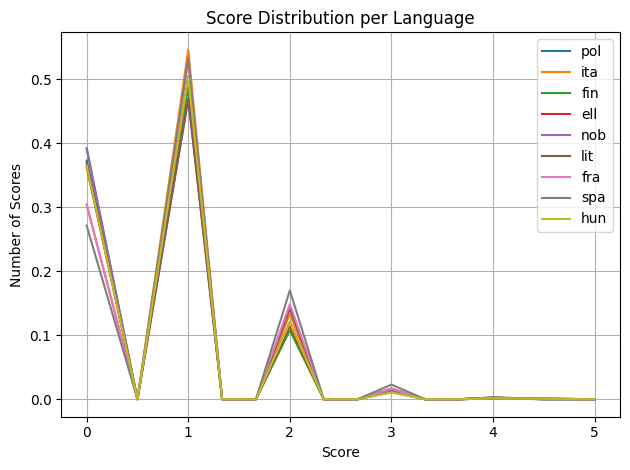

In [120]:
for lang, scores in lang_to_scores.items():
    num_scores = len(scores)
    counts = Counter(scores)
    x = sorted(counts.keys())
    y = [counts[val]/num_scores for val in x]
    plt.plot(x, y, label=lang)

plt.xlabel("Score")
plt.ylabel("Number of Scores")
plt.title("Score Distribution per Language")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

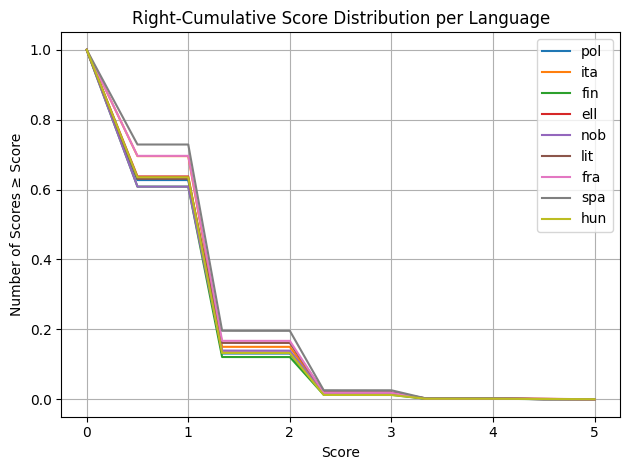

In [124]:
for lang, scores in lang_to_scores.items():
    num_scores = len(scores)
    counts = Counter(scores)
    all_scores = sorted(set(scores))
    
    # Ensure all relevant score levels are included
    all_scores_sorted = sorted(all_scores)

    # Compute cumulative counts from the right
    y_cumulative = []
    for i, score in enumerate(all_scores_sorted):
        count = sum(counts[s]/num_scores for s in all_scores_sorted[i:])
        y_cumulative.append(count)

    plt.plot(all_scores_sorted, y_cumulative, label=lang)

plt.xlabel("Score")
plt.ylabel("Number of Scores ≥ Score")
plt.title("Right-Cumulative Score Distribution per Language")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_path / f"llm_annotator_cummulative_score_dist_{model}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

In [139]:
language_codes_500k_docs = {
    "spa": "Spanish",
    "fra": "French",
    "ita": "Italian",
    "pol": "Polish",
    "ell": "Greek", # Modern Greek
    "nob": "Norwegian", # Norwegian Bokmål (dominant variety)
    "hun": "Hungarian",
    "fin": "Finnish",
    "lit": "Lithuanian",
}
model = ablated_models[2]
model_annotations_paths = list((annotated_500k_samples_path / f"{model}_aggregated").glob("**/*.jsonl"))
# filter only the languages that we want to check
model_annotations_paths = {path.stem.split("_")[0]: path for path in model_annotations_paths if path.stem.split("_")[0] in language_codes_500k_docs.keys()}
model_annotations_paths

{'pol': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/pol_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'ita': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/ita_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'fin': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregated/fin_Latn_sampled_500k_Mistral-Small-3.1-24B-Instruct-2503_aggregated_scores_majority.jsonl'),
 'ell': PosixPath('/raid/s3/opengptx/max_lue/repositories/ml_filter/ml_filter_paper/data/edu_content/predictions/educational_content/Mistral-Small-3.1-24B-Instruct-2503_aggregate

In [140]:
lang_to_scores = {lang: list() for lang in model_annotations_paths.keys()}

for lang, model_annotations_path in model_annotations_paths.items():
    with open(model_annotations_path, 'r') as f:
        for line in f:
            json_line = json.loads(line)
            try:
                score = float(json_line["score"])
            except: 
                continue
            lang_to_scores[lang].append(score)

In [141]:
series_list = []

for lang, scores in lang_to_scores.items():
    num_scores = len(scores)
    counts = Counter(scores)
    all_scores = sorted(set(scores))
    
    # Ensure all relevant score levels are included
    all_scores_sorted = sorted(all_scores)

    # Compute cumulative counts from the right
    y_cumulative = []
    for i, score in enumerate(all_scores_sorted):
        count = sum(counts[s]/num_scores for s in all_scores_sorted[i:])
        y_cumulative.append(count)
    
    series_list.append((all_scores_sorted, y_cumulative))

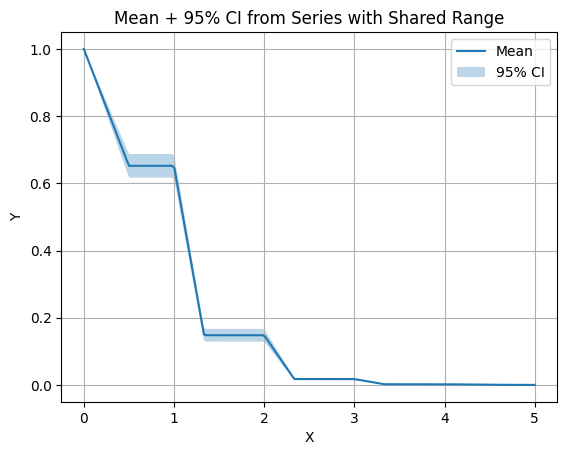

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example: All share same min/max x (0 to 4), but vary inside
# series_list = [

#     (np.array([0.0, 1.0, 2.5, 4.0]), np.array([1.0, 2.0, 1.5, 3.0])),
#     (np.array([0.0, 1.5, 3.0, 4.0]), np.array([1.2, 1.9, 2.0, 2.8])),
#     (np.array([0.0, 0.8, 2.0, 4.0]), np.array([0.8, 1.9, 1.4, 3.2])),
# ]

# Step 1: Define common grid
x_min = series_list[0][0][0]
x_max = series_list[0][0][-1]
common_x = np.linspace(x_min, x_max, 200)

# Step 2: Interpolate each series onto the grid
interpolated_ys = []
for x, y in series_list:
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(common_x))

Y = np.vstack(interpolated_ys)

# Step 3: Compute mean and 95% CI, ignoring NaNs
mean_y = np.nanmean(Y, axis=0)
std_y = np.nanstd(Y, axis=0)
n = np.sum(~np.isnan(Y), axis=0)
ci = 2.575 * std_y / np.sqrt(n)

# Step 4: Plot
plt.plot(common_x, mean_y, label='Mean')
plt.fill_between(common_x, mean_y - ci, mean_y + ci, alpha=0.3, label='95% CI')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Mean + 95% CI from Series with Shared Range")
plt.grid(True)
plt.show()

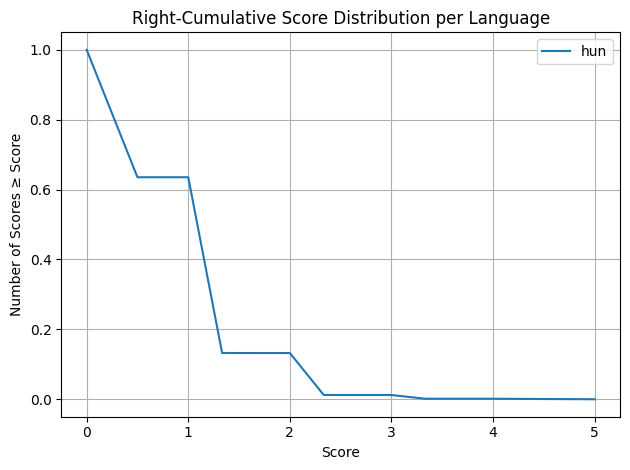

In [121]:
plt.plot(all_scores_sorted, y_cumulative, label=lang)

plt.xlabel("Score")
plt.ylabel("Number of Scores ≥ Score")
plt.title("Right-Cumulative Score Distribution per Language")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_path / f"llm_annotator_cummulative_score_dist_{model}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [110]:
y_cumulative

[1.0000000000000002,
 0.6353215582720513,
 0.6353175298556016,
 0.13247044652982135,
 0.1323314661623089,
 0.13232139512118482,
 0.13228916778958774,
 0.012359181667482417,
 0.012240343382218164,
 0.012232286549318893,
 0.012169846094349538,
 0.0015448977084353025,
 0.0015328124590863954,
 0.0015287840426367596,
 0.0015247556261871239,
 4.229837272117517e-05]

In [ ]:
series_list = []

for lang, scores in lang_to_scores.items():
    num_scores = len(scores)
    counts = Counter(scores)
    all_scores = sorted(set(scores))
    
    # Ensure all relevant score levels are included
    all_scores_sorted = sorted(all_scores)

    # Compute cumulative counts from the right
    y_cumulative = []
    for i, score in enumerate(all_scores_sorted):
        count = sum(counts[s]/num_scores for s in all_scores_sorted[i:])
        y_cumulative.append(count)
    
    series_list.append((all_scores_sorted, y_cumulative))